In [26]:
import cv2
import numpy as np
import mediapipe as mp
import logging
from math import sqrt
import time  # Import time module to manage timing

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose


In [27]:
# b is the midpoint of a and c (e.g. left hip, left elbow and left shoulder)
# our case will be left-hip, left-knee and left-ankle
def calculate_angle(a,b,c):
    a = np.array(a) # First
    b = np.array(b) # Mid
    c = np.array(c) # End
    
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)

    return angle 

def calculate_distance(p1, p2):
    return sqrt((p2[0] - p1[0]) ** 2 + (p2[1] - p1[1]) ** 2)

def should_start_timer(hip_velocity, knee_velocity, ankle_velocity, threshold_angle=100, hip_thresh=100, knee_thresh=100, ankle_thresh=50):
    """
    Determine if the timer should start based on velocity conditions.
    """
    return angle < threshold_angle and (hip_velocity > hip_thresh or knee_velocity > knee_thresh or ankle_velocity > ankle_thresh)

def determine_failure(elapsed_time, threshold_time=12):
    """
    Determine if the user has failed based on the elapsed time.
    """
    # convert elapsed time to seconds
    logging.info(f"Elapsed time: {elapsed_time}")
    return "FAILED" if elapsed_time > threshold_time else "PASSED"

In [28]:


# Initialize variables for counter logic
counter = 0
stage = None
confirm_frames = 5
stage_counter = 0
max_angle_per_rep = 0
last_angle = 0

# Initialize variables for optical flow
prev_frame = None
prev_hip = None
prev_knee = None
prev_ankle = None

# for optical flow postprocessing
hip_history = []
knee_history = []
ankle_history = []
ankle_velocity_history = []
knee_velocity_history = []
hip_velocity_history = []
frame_rate = None
frame_time = None
timer_started = False
start_time = None
elapsed_time = 0
finished = False
rep_durations = []  # List to store the duration of each repetition


with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    cap = cv2.VideoCapture("../test/CST_self2.mp4")
    frame_rate = cap.get(cv2.CAP_PROP_FPS)
    frame_time = 1/frame_rate

    while cap.isOpened() and not finished:
        if timer_started:
            elapsed_time = time.time() - start_time
            cv2.putText(image, f"Time: {elapsed_time:.2f} s", (480, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

        ret, frame = cap.read()
        
        if not ret:
            logging.warning("No frame captured from the video source.")
            break

        # Process the frame
        frame_height, frame_width, _ = frame.shape
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
        results = pose.process(image)
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        if results.pose_landmarks:
            landmarks = results.pose_landmarks.landmark

            # Extract coordinates multiplied by frame dimensions for optical flow and angle calculation
            hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x * frame_width, landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y * frame_height]
            knee = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].x * frame_width, landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].y * frame_height]
            ankle = [landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].x * frame_width, landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].y * frame_height]

                
            # Calculate angle for sit-stand logic
            angle = calculate_angle(hip, knee, ankle)
            if prev_hip and prev_knee and prev_ankle:
                # Calculate displacements
                hip_displacement = calculate_distance(prev_hip, hip)
                knee_displacement = calculate_distance(prev_knee, knee)
                ankle_displacement = calculate_distance(prev_ankle, ankle)

                # Calculate velocities
                hip_velocity = hip_displacement / frame_time
                knee_velocity = knee_displacement / frame_time
                ankle_velocity = ankle_displacement / frame_time
                ankle_velocity_history.append(ankle_velocity)
                knee_velocity_history.append(knee_velocity)
                hip_velocity_history.append(hip_velocity)
                
                if not timer_started and should_start_timer(angle, hip_velocity, knee_velocity, ankle_velocity):
                    start_time = time.time()
                    timer_started = True
                    logging.info("Timer started.")

                # Log or display velocities
                logging.info(f"Hip Velocity: {hip_velocity:.2f} px/s, Knee Velocity: {knee_velocity:.2f} px/s, Ankle Velocity: {ankle_velocity:.2f} px/s")
            # Optical flow visualization
            if prev_frame is not None:
                for prev_point, curr_point, color in zip([prev_hip, prev_knee, prev_ankle], [hip, knee, ankle], [(0, 0, 255)]*3):
                    prev_x, prev_y = map(int, prev_point)
                    curr_x, curr_y = map(int, curr_point)
                    cv2.circle(image, (curr_x, curr_y), 10, color, -1)
                    cv2.line(image, (prev_x, prev_y), (curr_x, curr_y), (0, 255, 0), 2)

            prev_frame = frame.copy()
            prev_hip, prev_knee, prev_ankle = hip, knee, ankle


            # Display the knee angle beside the knee
            cv2.putText(
                image,
                f"{angle} deg",
                (int(knee[0] + 60), int(knee[1])),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                (255, 255, 255),
                2,
                cv2.LINE_AA
            )

            # Counting logic
            if stage is None:
                stage = "up" if angle > 135 else "down"

            if stage == "down" and angle > 135:
                if stage_counter == 0:
                    rep_start_time = time.time()  # Reset start time at the beginning of a new rep
                stage_counter += 1
                if stage_counter >= confirm_frames:
                    stage = "up"
                    stage_counter = 0
                    counter += 1
                    logging.info(f"Transitioned to up. Total reps: {counter}")
                    max_angle_per_rep = 0  # Reset max angle for the new repetition
                    rep_duration = time.time() - rep_start_time
                    rep_durations.append(rep_duration)  # Store the duration of the rep
                    logging.info(f"Repetition {counter} completed in {rep_duration:.2f} seconds.")

                    
                    

            elif stage == "up" and angle < 105:
                stage_counter += 1
                if stage_counter >= confirm_frames:
                    stage = "down"
                    stage_counter = 0
                    logging.info("Transitioned to down.")
            if counter >= 5:  # Check if 5 reps are completed
                elapsed_time = time.time() - start_time
                logging.info(f"5 repetitions completed in {elapsed_time:.2f} seconds.")
                logging.info(f"Pass status: {determine_failure(elapsed_time)}")
                
                        
            cv2.putText(image, f"Time: {elapsed_time:.2f} s", (480, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

            # Update max angle
            if angle > max_angle_per_rep:
                max_angle_per_rep = angle
            last_angle = angle
            # Render curl counter
            
            if counter >= 5 and stage == "down":  # If 5 reps are completed
                finished = True  # Set finished to True to stop the loop
                logging.info(f"5 repetitions completed in {elapsed_time:.2f} seconds.")
            # Setup status box
            cv2.rectangle(image, (0, 0), (225, 73), (245, 117, 16), -1)

            # Rep data
            cv2.putText(
                image,
                "REPS",
                (15, 12),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                (0, 0, 0),
                1,
                cv2.LINE_AA,
            )
            cv2.putText(
                image,
                str(counter),
                (10, 60),
                cv2.FONT_HERSHEY_SIMPLEX,
                2,
                (255, 255, 255),
                2,
                cv2.LINE_AA,
            )

            # Stage data
            cv2.putText(
                image,
                "STAGE",
                (65, 12),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                (0, 0, 0),
                1,
                cv2.LINE_AA,
            )
            cv2.putText(
                image,
                stage,
                (60, 60),
                cv2.FONT_HERSHEY_SIMPLEX,
                2,
                (255, 255, 255),
                2,
                cv2.LINE_AA,
            )

            # Draw landmarks and connections
            mp_drawing.draw_landmarks(
                image,
                results.pose_landmarks,
                mp_pose.POSE_CONNECTIONS,
                mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=2),
                mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2),
            )
            
        cv2.imshow("Mediapipe Feed", image)
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

I0000 00:00:1717433546.326780 6604434 gl_context.cc:357] GL version: 2.1 (2.1 ATI-5.2.4), renderer: AMD Radeon Pro 5500M OpenGL Engine


/Users/brennanlee/Desktop/opencv-healthcare/myenv/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
2024-06-04 00:52:26,878 - INFO - Timer started.
2024-06-04 00:52:26,879 - INFO - Hip Velocity: 509.76 px/s, Knee Velocity: 11.72 px/s, Ankle Velocity: 395.52 px/s
2024-06-04 00:52:26,969 - INFO - Hip Velocity: 185.03 px/s, Knee Velocity: 28.93 px/s, Ankle Velocity: 299.51 px/s
2024-06-04 00:52:27,053 - INFO - Hip Velocity: 287.39 px/s, Knee Velocity: 21.44 px/s, Ankle Velocity: 148.51 px/s
2024-06-04 00:52:27,133 - INFO - Hip Velocity: 274.70 px/s, Knee Velocity: 3.27 px/s, Ankle Velocity: 205.28 px/s
2024-06-04 00:52:27,212 - INFO - Hip Velocity: 84.48 px/s, Knee Velocity: 22.11 px/s, Ankle Velocity: 40.64 px/s
2024-06-04 00:52:27,292 - I

In [31]:
ankle_velocity_history = np.array(ankle_velocity_history)
ankle_velocity_history

array([3.95523167e+02, 2.99506872e+02, 1.48510453e+02, 2.05284886e+02,
       4.06364832e+01, 7.56776684e+01, 9.17848872e+01, 8.11566356e+01,
       8.75758520e+01, 8.73218814e+01, 7.70272609e+01, 2.92475931e+02,
       3.41788736e+02, 2.39605539e+02, 1.12613918e+02, 4.66274779e+01,
       6.76990588e+01, 3.19902002e+02, 2.09183008e+02, 6.74838066e+01,
       6.81493242e+01, 7.84733240e+01, 2.97247773e+01, 2.75033058e+01,
       6.32160003e+00, 2.99611549e+01, 2.51244735e+01, 6.52611848e+01,
       6.08564479e+01, 7.50031276e+01, 1.37003709e+01, 8.66559857e+00,
       8.43226410e+00, 1.05349274e+01, 1.25302127e+01, 7.58887304e+00,
       7.30758444e+00, 3.42722947e+01, 1.40972861e+01, 3.50930773e+01,
       8.98378384e+01, 3.52101389e+01, 9.03231082e+01, 1.36492237e+02,
       5.15549531e+01, 4.58563888e+01, 1.49792140e+01, 1.29546043e+02,
       6.67114937e+00, 9.35183907e+01, 7.70149772e+01, 8.26579491e+01,
       1.39907396e+02, 3.17490726e+02, 1.20657073e+02, 1.90157530e+02,
      

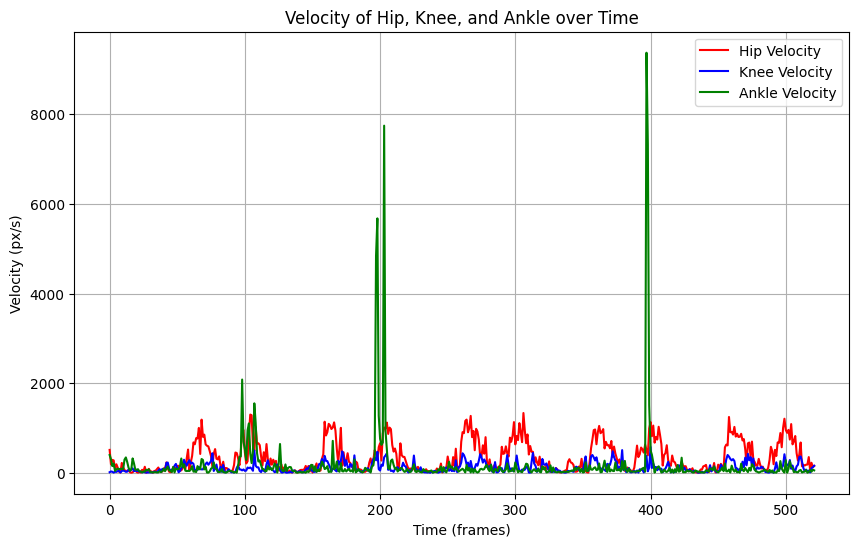

In [33]:
import matplotlib.pyplot as plt

time_steps = list(range(len(hip_velocity_history)))  # Generate time steps equal to the number of velocity measurements

# Plotting the velocities
plt.figure(figsize=(10, 6))
plt.plot(time_steps, hip_velocity_history, label='Hip Velocity', color='red')
plt.plot(time_steps, knee_velocity_history, label='Knee Velocity', color='blue')
plt.plot(time_steps, ankle_velocity_history, label='Ankle Velocity', color='green')
plt.xlabel('Time (frames)')
plt.ylabel('Velocity (px/s)')
plt.title('Velocity of Hip, Knee, and Ankle over Time')
plt.legend()
plt.grid(True)
plt.show()


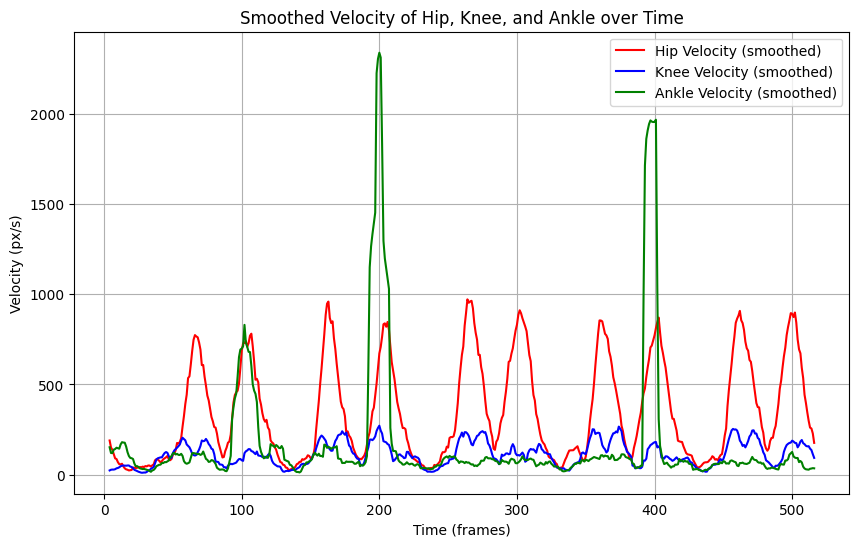

In [34]:
# 1. Velocity Smoothness Graphs
# Plotting the moving average or applying a low-pass filter to the velocity data can help in visualizing the smoothness by reducing the noise and highlighting the general trend of the movement.

# Example Plot - Moving Average of Velocity:
import numpy as np
import matplotlib.pyplot as plt

def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Example data
time_steps = np.arange(len(hip_velocity_history))

# Calculate moving averages
hip_ma = moving_average(hip_velocity_history, window_size=10)
knee_ma = moving_average(knee_velocity_history, window_size=10)
ankle_ma = moving_average(ankle_velocity_history, window_size=10)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(time_steps[4:-5], hip_ma, label='Hip Velocity (smoothed)', color='red')
plt.plot(time_steps[4:-5], knee_ma, label='Knee Velocity (smoothed)', color='blue')
plt.plot(time_steps[4:-5], ankle_ma, label='Ankle Velocity (smoothed)', color='green')
plt.xlabel('Time (frames)')
plt.ylabel('Velocity (px/s)')
plt.title('Smoothed Velocity of Hip, Knee, and Ankle over Time')
plt.legend()
plt.grid(True)
plt.show()


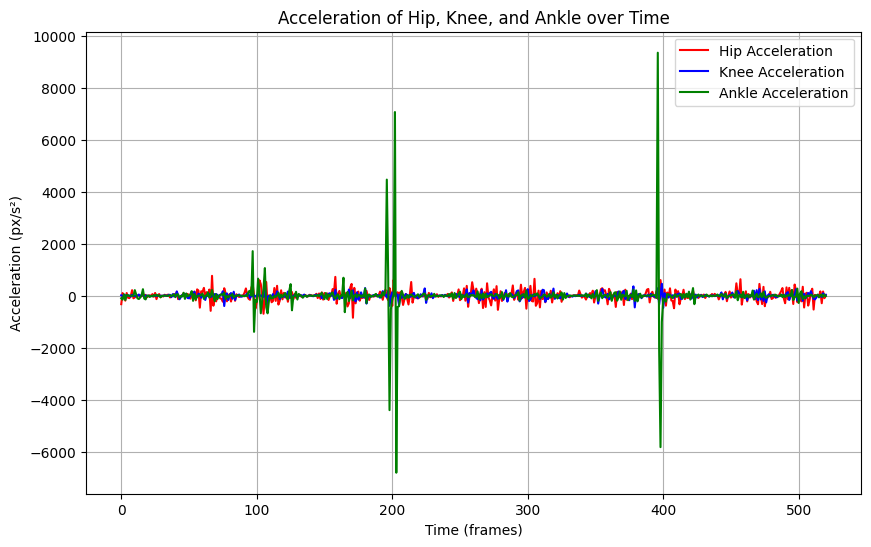

In [35]:
# 2. Acceleration Graphs
# Acceleration can be calculated as the derivative of velocity. By plotting acceleration, you can assess how abrupt or smooth the changes in velocity are, which reflects on the motion's smoothness.

# Example Plot - Acceleration:
# Calculate acceleration as the difference of velocity
hip_acceleration = np.diff(hip_velocity_history, n=1)
knee_acceleration = np.diff(knee_velocity_history, n=1)
ankle_acceleration = np.diff(ankle_velocity_history, n=1)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(time_steps[:-1], hip_acceleration, label='Hip Acceleration', color='red')
plt.plot(time_steps[:-1], knee_acceleration, label='Knee Acceleration', color='blue')
plt.plot(time_steps[:-1], ankle_acceleration, label='Ankle Acceleration', color='green')
plt.xlabel('Time (frames)')
plt.ylabel('Acceleration (px/s²)')
plt.title('Acceleration of Hip, Knee, and Ankle over Time')
plt.legend()
plt.grid(True)
plt.show()


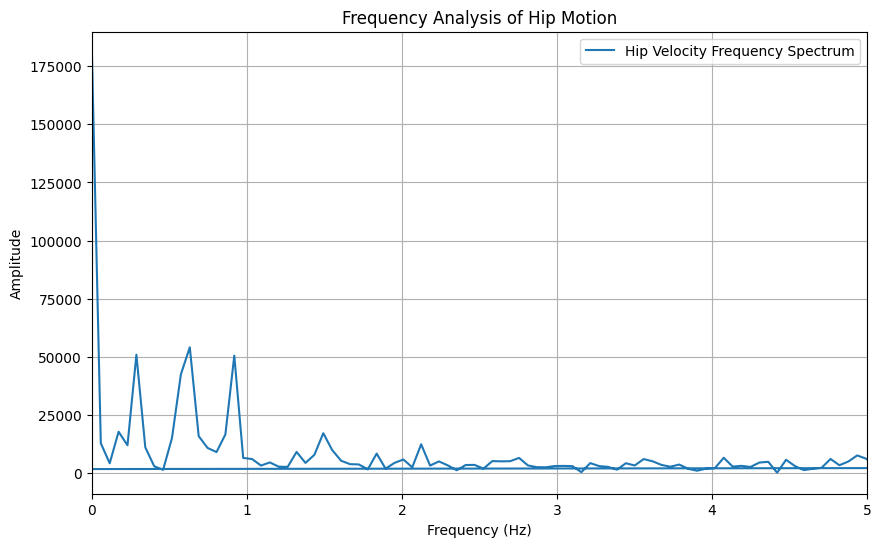

In [36]:
# 4. Frequency Analysis
# Performing a Fourier Transform to analyze the frequency components of the motion can also help in identifying the smoothness. Smooth motions typically have fewer high-frequency components.

# Example of Frequency Analysis Plot:
from scipy.fft import fft, fftfreq

# Calculate FFT
hip_fft = fft(hip_velocity_history)
frequencies = fftfreq(len(hip_velocity_history), d=frame_time)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(frequencies, np.abs(hip_fft), label='Hip Velocity Frequency Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Frequency Analysis of Hip Motion')
plt.xlim([0, 5])  # Limiting to relevant frequencies
plt.legend()
plt.grid(True)
plt.show()
